# Extract boxes with PyTorch

In [33]:
%load_ext autoreload
%autoreload 2

import os, glob, json, tqdm, pandas
import matplotlib.pyplot as plt
%pylab inline

import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch.optim import Adam

from imgaug import augmenters as iaa
from imgaug import imgaug as ia
from PIL import Image

from IPython.display import display

from prepare_images_utils import *
from latex_dataset import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'identity']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Prepare data source

In [2]:
SRC_DIR = '/notebook/generated/src/'

In [3]:
all_image_ids = [os.path.basename(fname)[:-9]
                 for fname in glob.glob(os.path.join(SRC_DIR, '*_out.json'))]
random.shuffle(all_image_ids)

TOTAL_SAMPLES = len(all_image_ids)
TRAIN_SAMPLES = int(TOTAL_SAMPLES * 0.8)
VAL_SAMPLES = TOTAL_SAMPLES - TRAIN_SAMPLES
train_image_ids = all_image_ids[:TRAIN_SAMPLES]
val_image_ids = all_image_ids[TRAIN_SAMPLES:]

In [4]:
def load_image_with_boxes(img_id):
    img = load_image_opaque(os.path.join(SRC_DIR, img_id + '_in.png'))
    with open(os.path.join(SRC_DIR, img_id + '_out.json'), 'r') as f:
        boxes = json.load(f)
    return img, boxes


def prepare_img_boxes_for_nn(img, boxes, shape=(600, 600)):
    cats, just_boxes = zip(*boxes)
    cats = numpy.array(cats)
    just_boxes = numpy.array(just_boxes) * POINTS_TO_PIXELS_FACTOR
    just_boxes = just_boxes[:, [1, 0, 3, 2]] # x1, y1, x2, y2
    cropbox = numpy.array((just_boxes[:, 0].min(),
                           just_boxes[:, 1].min(),
                           just_boxes[:, 2].max(),
                           just_boxes[:, 3].max()))

    res_in_img = Image.new('L', shape, 255)
    res_in_img.paste(img.crop(cropbox))

    just_boxes -= cropbox[[0, 1, 0, 1]]
    just_boxes = numpy.clip(just_boxes,
                            (0, 0, 0, 0),
                            (shape[0], shape[1], shape[0], shape[1]))
    boxes_area = (just_boxes[:, 2] - just_boxes[:, 0]) * (just_boxes[:, 3] - just_boxes[:, 1])
    good_boxes = numpy.where(boxes_area > 0)[0]
    return (numpy.array(res_in_img).astype('float32') / 255,
            cats[good_boxes],
            just_boxes[good_boxes])


TOTAL_CLASSES = 5
def make_mask_for_nn(size, box_cats, boxes_on_image):
    result = numpy.zeros((TOTAL_CLASSES, ) + size, dtype='float32')
    for cat, bbox in zip(box_cats, boxes_on_image.bounding_boxes):
        result[cat, int(bbox.y1):int(bbox.y2+1), int(bbox.x1):int(bbox.x2+1)] = 1
    return result


def calc_loss_weights(mask):
arr_to_img(cv2.Laplacian(test_batch[2][0][4], cv2.CV_32F, ksize=5))


def data_gen(image_ids, augmenter, batch_size=32):
    while True:
        batch_image_ids = numpy.random.choice(image_ids, size=batch_size)
        images, box_cats, boxes = zip(*[prepare_img_boxes_for_nn(*load_image_with_boxes(img_id))
                                        for img_id in batch_image_ids])

        det = augmenter.to_deterministic() if not augmenter.deterministic else augseq

        images_aug = det.augment_images(images)

        boxes = [ia.BoundingBoxesOnImage([ia.BoundingBox(*box)
                                          for box in img_boxes],
                                         img.shape)
                 for img, img_boxes in zip(images, boxes)]
        boxes_aug = det.augment_bounding_boxes(boxes)
        
        mask = numpy.array([make_mask_for_nn(img.shape, img_box_cats, img_boxes)
                            for img, img_box_cats, img_boxes
                            in zip(images_aug, box_cats, boxes_aug)])
        yield (batch_image_ids, numpy.expand_dims(numpy.array(images_aug), 1), mask, boxes_aug)

In [5]:
imgaug_pipeline = iaa.Sequential([
#     iaa.Fliplr(0.5), # horizontally flip 50% of the images
#     iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
])

## Define a network

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilations=[1], padding=1, bn=True):
        super(ConvBlock, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels,
                                              out_channels,
                                              kernel_size,
                                              padding=padding,
                                              dilation=dil)
                                    for dil in dilations])

    def forward(self, x):
        x = self.bn(x)
        return F.relu(torch.cat([conv(x) for conv in self.convs], dim=1))


class UNet(nn.Module):
    def __init__(self, out_channels=TOTAL_CLASSES, first_conv_channels=4, depth=2, out_layers=1, conv_kernel=(3, 3),
                 enc_dilations=[1], dec_dilations=[1]):
        super(UNet, self).__init__()
        enc_channels = [1] + [first_conv_channels * (2**step) for step in range(depth)]
        self.encoder = nn.ModuleList([ConvBlock(enc_channels[i],
                                                enc_channels[i+1],
                                                conv_kernel,
                                                dilations=enc_dilations)
                                      for i in range(depth)])
        bottleneck_channels = enc_channels[-1] * 2
        self.bottleneck = ConvBlock(enc_channels[-1],
                                    bottleneck_channels,
                                    conv_kernel,
                                    dilations=enc_dilations)
        dec_channels = [bottleneck_channels] + enc_channels[:0:-1]
        self.dec_conv = nn.ModuleList([ConvBlock(dec_channels[i],
                                                 dec_channels[i+1],
                                                 conv_kernel,
                                                 dilations=dec_dilations)
                                      for i in range(depth)])
        self.dec_deconv = nn.ModuleList([nn.ConvTranspose2d(dec_channels[i],
                                                            dec_channels[i+1],
                                                            (2, 2),
                                                            stride=2)
                                         for i in range(depth)])
        self.out_layers = nn.ModuleList([ConvBlock(dec_channels[-1],
                                                   dec_channels[-1],
                                                   conv_kernel,
                                                   dilations=dec_dilations)])
        self.out_conv = nn.Conv2d(dec_channels[-1],
                                  out_channels,
                                  (1, 1))

    def forward(self, x):
        enc_conv_outs = []
        enc_pool_outs = [x]
        enc_pool_idx = []
        for enc_conv in self.encoder:
            cur_conv_out = enc_conv(enc_pool_outs[-1])
            enc_conv_outs.append(cur_conv_out)
            cur_pool_out = F.max_pool2d(cur_conv_out, (2, 2))
            enc_pool_outs.append(cur_pool_out)
            enc_pool_idx.append(cur_pool_idx)

        cur_out = self.bottleneck(enc_pool_outs[-1])

        for dec_step, (dec_conv, dec_deconv) in enumerate(zip(self.dec_conv, self.dec_deconv)):
            up = dec_deconv(cur_out)
            cur_out = torch.cat([up, enc_conv_outs[-dec_step-1]], dim=1)
            cur_out = dec_conv(cur_out)

        for out_layer in self.out_layers:
            cur_out = F.relu(out_layer(cur_out))

        return F.sigmoid(self.out_conv(cur_out))

## Train

In [44]:
def mcuda(x, cuda):
    return x.cuda() if cuda else x


def npvar(arr, cuda):
    return mcuda(Variable(torch.from_numpy(arr)), cuda)


def dice_loss(pred, target):
    smooth = 1.

    pflat = pred.view(-1)
    tflat = target.view(-1)
    intersection = (pflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /
                (pflat.sum() + tflat.sum() + smooth))


def run_network(network, generator, num_batches, criterion=dice_loss, optimizer=None, cuda=True):
    metrics = []
    gen_iter = iter(generator)
    for _ in tqdm.tqdm(range(num_batches)):
        image_ids, images, mask, boxes = next(gen_iter)
        mask_var = npvar(mask, cuda)
        cur_out = network(npvar(images, cuda))

        loss = criterion(cur_out, mask_var)

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm(network.parameters(), 10)
            optimizer.step()

        cur_metrics = { 'loss' : loss.data[0] }
        metrics.append(cur_metrics)
    return metrics

In [ ]:
%%prun
EPOCHS_NUM = 10
BATCHES_PER_EPOCH_TRAIN = 200
BATCHES_PER_EPOCH_VAL = 20

BATCH_SIZE = 8
train_gen = data_gen(train_image_ids, imgaug_pipeline, batch_size=BATCH_SIZE)
val_gen = data_gen(val_image_ids, imgaug_pipeline, batch_size=BATCH_SIZE)

net = UNet(first_conv_channels=8, depth=3, enc_dilations=[1]).cuda()
optimizer = Adam(net.parameters())
print('total parameters', sum(numpy.product(p.size()) for p in net.parameters()))

train_metrics = []
val_metrics = []
for epoch in range(EPOCHS_NUM):
    print('epoch', epoch)
    cur_train_metrics = run_network(net, train_gen, BATCHES_PER_EPOCH_TRAIN,
                                    optimizer=optimizer)
    train_metrics.extend(cur_train_metrics)
    display(pandas.DataFrame(cur_train_metrics).describe().loc[['mean', 'std']])

    cur_val_metrics = run_network(net, val_gen, BATCHES_PER_EPOCH_VAL)
    val_metrics.extend(cur_val_metrics)
    display(pandas.DataFrame(cur_val_metrics).describe().loc[['mean', 'std']])


  0%|          | 0/200 [00:00<?, ?it/s]

total parameters 60423
epoch 0



  3%|▎         | 6/200 [00:01<01:00,  3.20it/s]
Exception in thread Thread-989:
Traceback (most recent call last):
  File "/root/.pyenv/versions/3.6.0/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/root/.pyenv/versions/3.6.0/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 200/200 [00:59<00:00,  3.34it/s]


,loss
mean,0.519798
std,0.264356


100%|██████████| 20/20 [00:03<00:00,  5.36it/s]


,loss
mean,0.134852
std,0.006579


  0%|          | 0/200 [00:00<?, ?it/s]

epoch 1


100%|██████████| 200/200 [01:00<00:00,  3.33it/s]


,loss
mean,0.085327
std,0.024822


100%|██████████| 20/20 [00:03<00:00,  5.37it/s]


,loss
mean,0.063611
std,0.008696


  0%|          | 0/200 [00:00<?, ?it/s]

epoch 2


100%|██████████| 200/200 [00:59<00:00,  3.34it/s]


,loss
mean,0.062029
std,0.008366


100%|██████████| 20/20 [00:03<00:00,  5.46it/s]


,loss
mean,0.059157
std,0.008804


  0%|          | 0/200 [00:00<?, ?it/s]

epoch 3


 12%|█▏        | 24/200 [00:07<00:52,  3.32it/s]

In [46]:
train_metrics = pandas.DataFrame(train_metrics)
val_metrics = pandas.DataFrame(val_metrics)

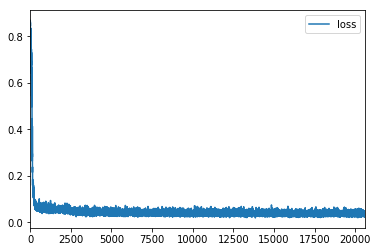

In [47]:
train_metrics.plot()

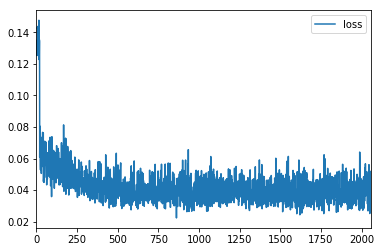

In [48]:
val_metrics.plot()

## Predict and visualize

In [63]:
torch.save(net, 'models/torch1')

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type ConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [64]:
test_net = net.cpu()

In [66]:
test_batch = next(iter(val_gen))
test_pred = net(npvar(test_batch[1], False))
test_pred_np = test_pred.data.numpy()

In [72]:
test_batch[1][0][0]

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]], dtype=float32)

In [89]:
cv2.Cannytest_batch[2][0][1]

array([[ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

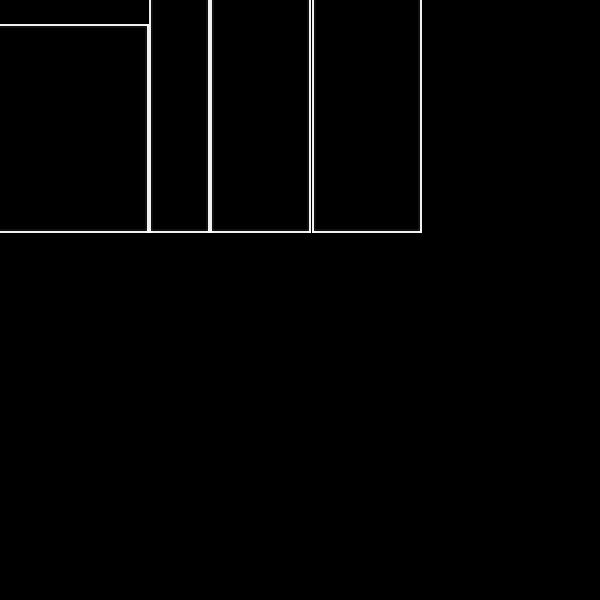

In [107]:
arr_to_img(cv2.Laplacian(test_batch[2][0][4], cv2.CV_32F, ksize=5))

In [99]:
cv2.Laplacian?

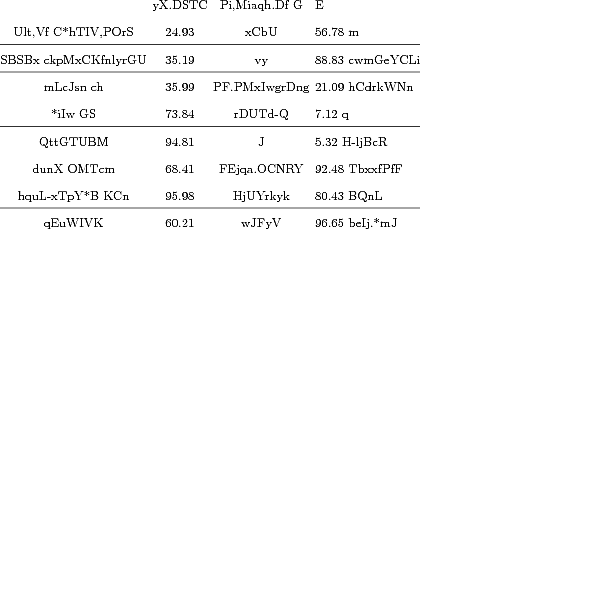

In [73]:
arr_to_img(test_batch[1][0][0])

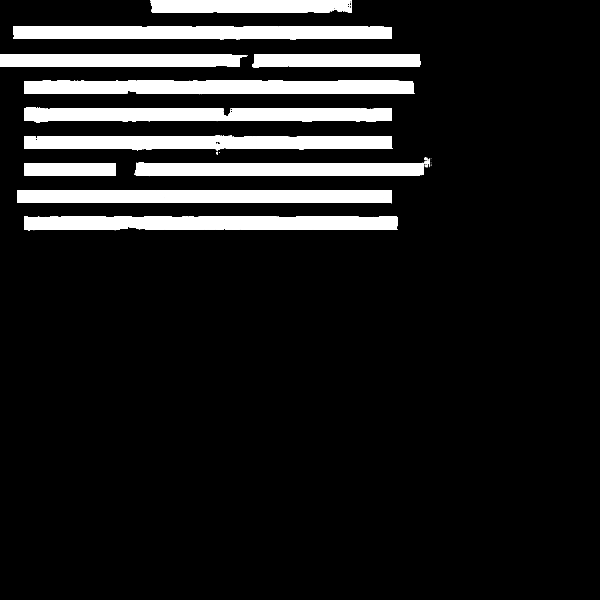

In [85]:
arr_to_img(test_pred_np[0][3])